In [8]:
import os
from os.path import join as pjoin
from scipy.io import wavfile

data_dir = pjoin(os.getcwd(),"../AudioFiles","wavs")
wav_fname = pjoin(data_dir, '55_tdcast.wav')

In [13]:
samplerate, original_data = wavfile.read(wav_fname)
print(f"number of channels = {data.shape[1]}")

length = data.shape[0] / samplerate
print(f"length = {length}s")

number of channels = 2
length = 1379.3697959183673s


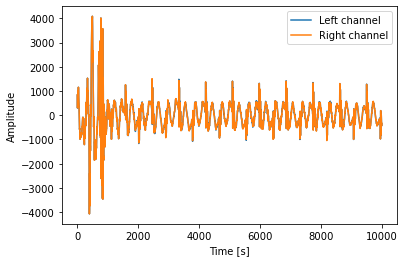

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# time = np.linspace(0., 10000, data.shape[0])
plt.plot(data[10000:20000, 0], label="Left channel")
plt.plot(data[10000:20000, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [12]:
import simpleaudio as sa

audio = data[10000:200000, 0].astype(np.int16)

# Start playback
play_obj = sa.play_buffer(audio, 1, 2, samplerate)

# Wait for playback to finish before exiting
play_obj.wait_done()